In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# input_dir = '/gdrive/MyDrive/downsampled_250/'
# target_dir = '/gdrive/MyDrive/downsampled_mask_250/'
# input_dir = '/gdrive/MyDrive/Propulsion Academy/_zurich_balanced_125_aug/'
# target_dir = '/gdrive/MyDrive/images_125_6classes/_zurich_balanced_125_aug_mask/'
# input_dir = '/gdrive/MyDrive/Propulsion Academy/_switzerland_balanced_125_red/'
# target_dir = '/gdrive/MyDrive/Propulsion Academy/_switzerland_balanced_125_mask_6classes/'
input_dir = '/gdrive/MyDrive/Propulsion Academy/input'
target_dir = '/gdrive/MyDrive/Propulsion Academy/target'

In [ ]:
#extract images
# import zipfile
# path_to_zip = '/gdrive/MyDrive/Propulsion Academy/OSM_input.zip'
# path_to_save = '/gdrive/MyDrive/Propulsion Academy/'
# with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
#         zip_ref.extractall(path_to_save)

In [ ]:
from IPython.display import Image, display, clear_output
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import os
import tensorflow as tf
import tensorflow_datasets as tfds


In [ ]:
img_size = (128, 128)
num_classes = 7
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".tif")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".tif") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


Number of samples: 184524
/gdrive/MyDrive/Propulsion Academy/input/swissimage-dop10_2017_2585150-1110150_0.4_2056_h.tif | /gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585150-1110150_0.4_2056_h.tif
/gdrive/MyDrive/Propulsion Academy/input/swissimage-dop10_2017_2585150-1110150_0.4_2056_v.tif | /gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585150-1110150_0.4_2056_v.tif
/gdrive/MyDrive/Propulsion Academy/input/swissimage-dop10_2017_2585300-1114550_0.4_2056_h.tif | /gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585300-1114550_0.4_2056_h.tif
/gdrive/MyDrive/Propulsion Academy/input/swissimage-dop10_2017_2585300-1114550_0.4_2056_v.tif | /gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585300-1114550_0.4_2056_v.tif
/gdrive/MyDrive/Propulsion Academy/input/swissimage-dop10_2017_2585300-1114600_0.4_2056_h.tif | /gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585300-1114600_0.4_2056_

In [ ]:
len(input_img_paths), len(target_img_paths)

(184524, 184524)

In [ ]:
target_img_paths[10:20]

['/gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585400-1114600_0.4_2056_h.tif',
 '/gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585400-1114600_0.4_2056_v.tif',
 '/gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585500-1112750_0.4_2056_h.tif',
 '/gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585500-1112750_0.4_2056_v.tif',
 '/gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585650-1115700_0.4_2056_h.tif',
 '/gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585650-1115700_0.4_2056_v.tif',
 '/gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585700-1115600_0.4_2056_h.tif',
 '/gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585700-1115600_0.4_2056_v.tif',
 '/gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop10_2017_2585750-1117700_0.4_2056_h.tif',
 '/gdrive/MyDrive/Propulsion Academy/target/mask_swissimage-dop1

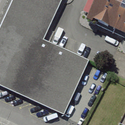

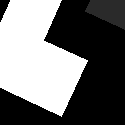

In [ ]:
# Display input image #7
display(PIL.Image.open(input_img_paths[90137]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[90137]))
display(img)

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class geoswiss(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

In [ ]:
import random

# Split our img paths into a training, validation and a test set
train_samples = int(len(input_img_paths) * 0.8 * 0.8)
val_samples = int(len(input_img_paths) * 0.8)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:train_samples]
train_target_img_paths = target_img_paths[:train_samples]
val_input_img_paths = input_img_paths[train_samples:val_samples]
val_target_img_paths = target_img_paths[train_samples:val_samples]
test_input_img_paths = input_img_paths[val_samples:]
test_target_img_paths = target_img_paths[val_samples:]

# Instantiate data Sequences for each split
train_gen = geoswiss(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = geoswiss(batch_size, img_size, val_input_img_paths, val_target_img_paths)
test_gen = geoswiss(batch_size, img_size, test_input_img_paths, test_target_img_paths)

In [ ]:
# UNet Model by @nikhilroxtomar


# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import ResNet50

# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(input)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     return x

# def decoder_block(input, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# def build_resnet50_unet(input_shape):
#     """ Input """
#     inputs = Input(input_shape)

#     """ Pre-trained ResNet50 Model """
#     resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

#     """ Encoder """
#     s1 = resnet50.get_layer("input_1").output           ## (512 x 512) 128
#     s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256) 64
#     s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128) 32
#     s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64) 16

#     """ Bridge """
#     b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

#     """ Decoder """
#     d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
#     d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
#     d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
#     d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

#     """ Output """
#     outputs = Conv2D(7, 1, padding="same", activation="softmax")(d4)

#     model = Model(inputs, outputs)
#     return model


# input_shape = (128, 128, 3)
# model = build_resnet50_unet(input_shape)
# model.summary()

In [ ]:
# model = keras.models.load_model('/gdrive/MyDrive/Propulsion Academy/models/save_ResNet50_UNet_125_6classes.h5')
# model.load_weights("/gdrive/MyDrive/Propulsion Academy/models/weights_ResNet50_UNet_125_6classes.ckpt")
model = keras.models.load_model('/gdrive/MyDrive/temp/ResNet50/save_ResNet50_UNet_125_6classes.h5')
model.load_weights('/gdrive/MyDrive/temp/ResNet50/weights_ResNet50_UNet_125_6classes.ckpt')

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("/gdrive/MyDrive/Propulsion Academy/models/ResNet50_UNet_125_6classes_25May.h5", 
                                    save_best_only=True),
    #keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, min_delta=.001)
 
]

In [ ]:
#model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss="sparse_categorical_crossentropy" , metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Train the model, doing validation at the end of each epoch.
epochs = 1
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

In [ ]:
model.save('/gdrive/MyDrive/Propulsion Academy/models/save_ResNet50_UNet_125_6classes.h5')
model.save_weights("/gdrive/MyDrive/Propulsion Academy/models/weights_ResNet50_UNet_125_6classes.ckpt")

In [ ]:
new_epochs = 9
epochs += new_epochs
model_history = model.fit(train_gen, epochs=epochs, 
                                initial_epoch=model_history.epoch[-1]+1,
                                validation_data=val_gen, callbacks=callbacks)

In [ ]:
test_gen = geoswiss(batch_size, img_size, test_input_img_paths[:512], test_target_img_paths[:512])
test_preds = model.predict(test_gen, verbose=1)

In [ ]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = keras.preprocessing.image.array_to_img(mask)
    display(img)


# Display results for validation image #10
i = 179

# Display input image
#display(Image(filename=val_input_img_paths[i]))
img = (load_img(test_input_img_paths[i]))
display(img)


# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(test_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i) 